# COMS 4995 AML HW3

Huazhang Liu

Jianfeng Zhuang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.impute import KNNImputer

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [4]:
from sklearn.model_selection import cross_val_score

In [5]:
pd.options.display.max_columns = 100

In [6]:
data = pd.read_csv("vehicles.csv")

In [17]:
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,WVWPF7AJ6CW316713,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,1FTMF1EP3GKF13544,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,clean,automatic,3GTU2WEC6FG228025,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,1FTEX1EF6GKD25447,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,clean,automatic,1FT8W4DT8GEA90427,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [18]:
columns = np.array(data.columns)
print(columns)

['id' 'url' 'region' 'region_url' 'price' 'year' 'manufacturer' 'model'
 'condition' 'cylinders' 'fuel' 'odometer' 'title_status' 'transmission'
 'vin' 'drive' 'size' 'type' 'paint_color' 'image_url' 'description'
 'county' 'state' 'lat' 'long']


## Identify Features

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            509577 non-null  int64  
 1   url           509577 non-null  object 
 2   region        509577 non-null  object 
 3   region_url    509577 non-null  object 
 4   price         509577 non-null  int64  
 5   year          508050 non-null  float64
 6   manufacturer  486813 non-null  object 
 7   model         501588 non-null  object 
 8   condition     277643 non-null  object 
 9   cylinders     309894 non-null  object 
 10  fuel          505592 non-null  object 
 11  odometer      417253 non-null  float64
 12  title_status  506515 non-null  object 
 13  transmission  505858 non-null  object 
 14  vin           302152 non-null  object 
 15  drive         365434 non-null  object 
 16  size          167574 non-null  object 
 17  type          368046 non-null  object 
 18  pain

#### From this, we know that the "county" column is meaningless, because it is completely missing. So we drop this column.

In [8]:
new_data = data.drop("county", axis = 1)

#### Remove observations that have prices less than 5, then calculate IQR and remove all the outliers.

In [9]:
new_data = new_data.loc[data['price'] > 5,]
price_Q1 = new_data['price'].quantile(0.25)
price_Q3 = new_data['price'].quantile(0.75)
price_IQR = price_Q3 - price_Q1
new_data = new_data.loc[(new_data['price'] > price_Q1 - 1.5 * price_IQR) & (new_data['price'] < price_Q3 + 1.5 * price_IQR)]

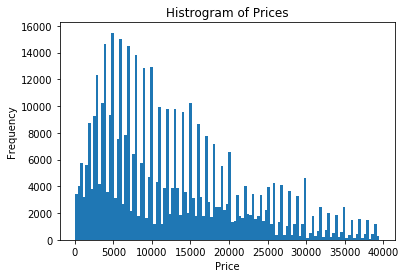

In [10]:
plt.hist(new_data['price'], bins = "auto")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histrogram of Prices")
plt.show()

#### There are total of 509577 non-null observations, while 447819 of them are unique. This means that if we include id in our models, it is going to leak the information.

In [11]:
np.unique(new_data['id']).shape

(447819,)

In [12]:
new_data = new_data.drop('id', axis=1)

#### Same thing happens on the column "url"

In [13]:
np.unique(new_data['url']).shape

(447819,)

In [14]:
new_data = new_data.drop('url', axis=1)

#### The column "region" can be left as a categorical feature for the model.

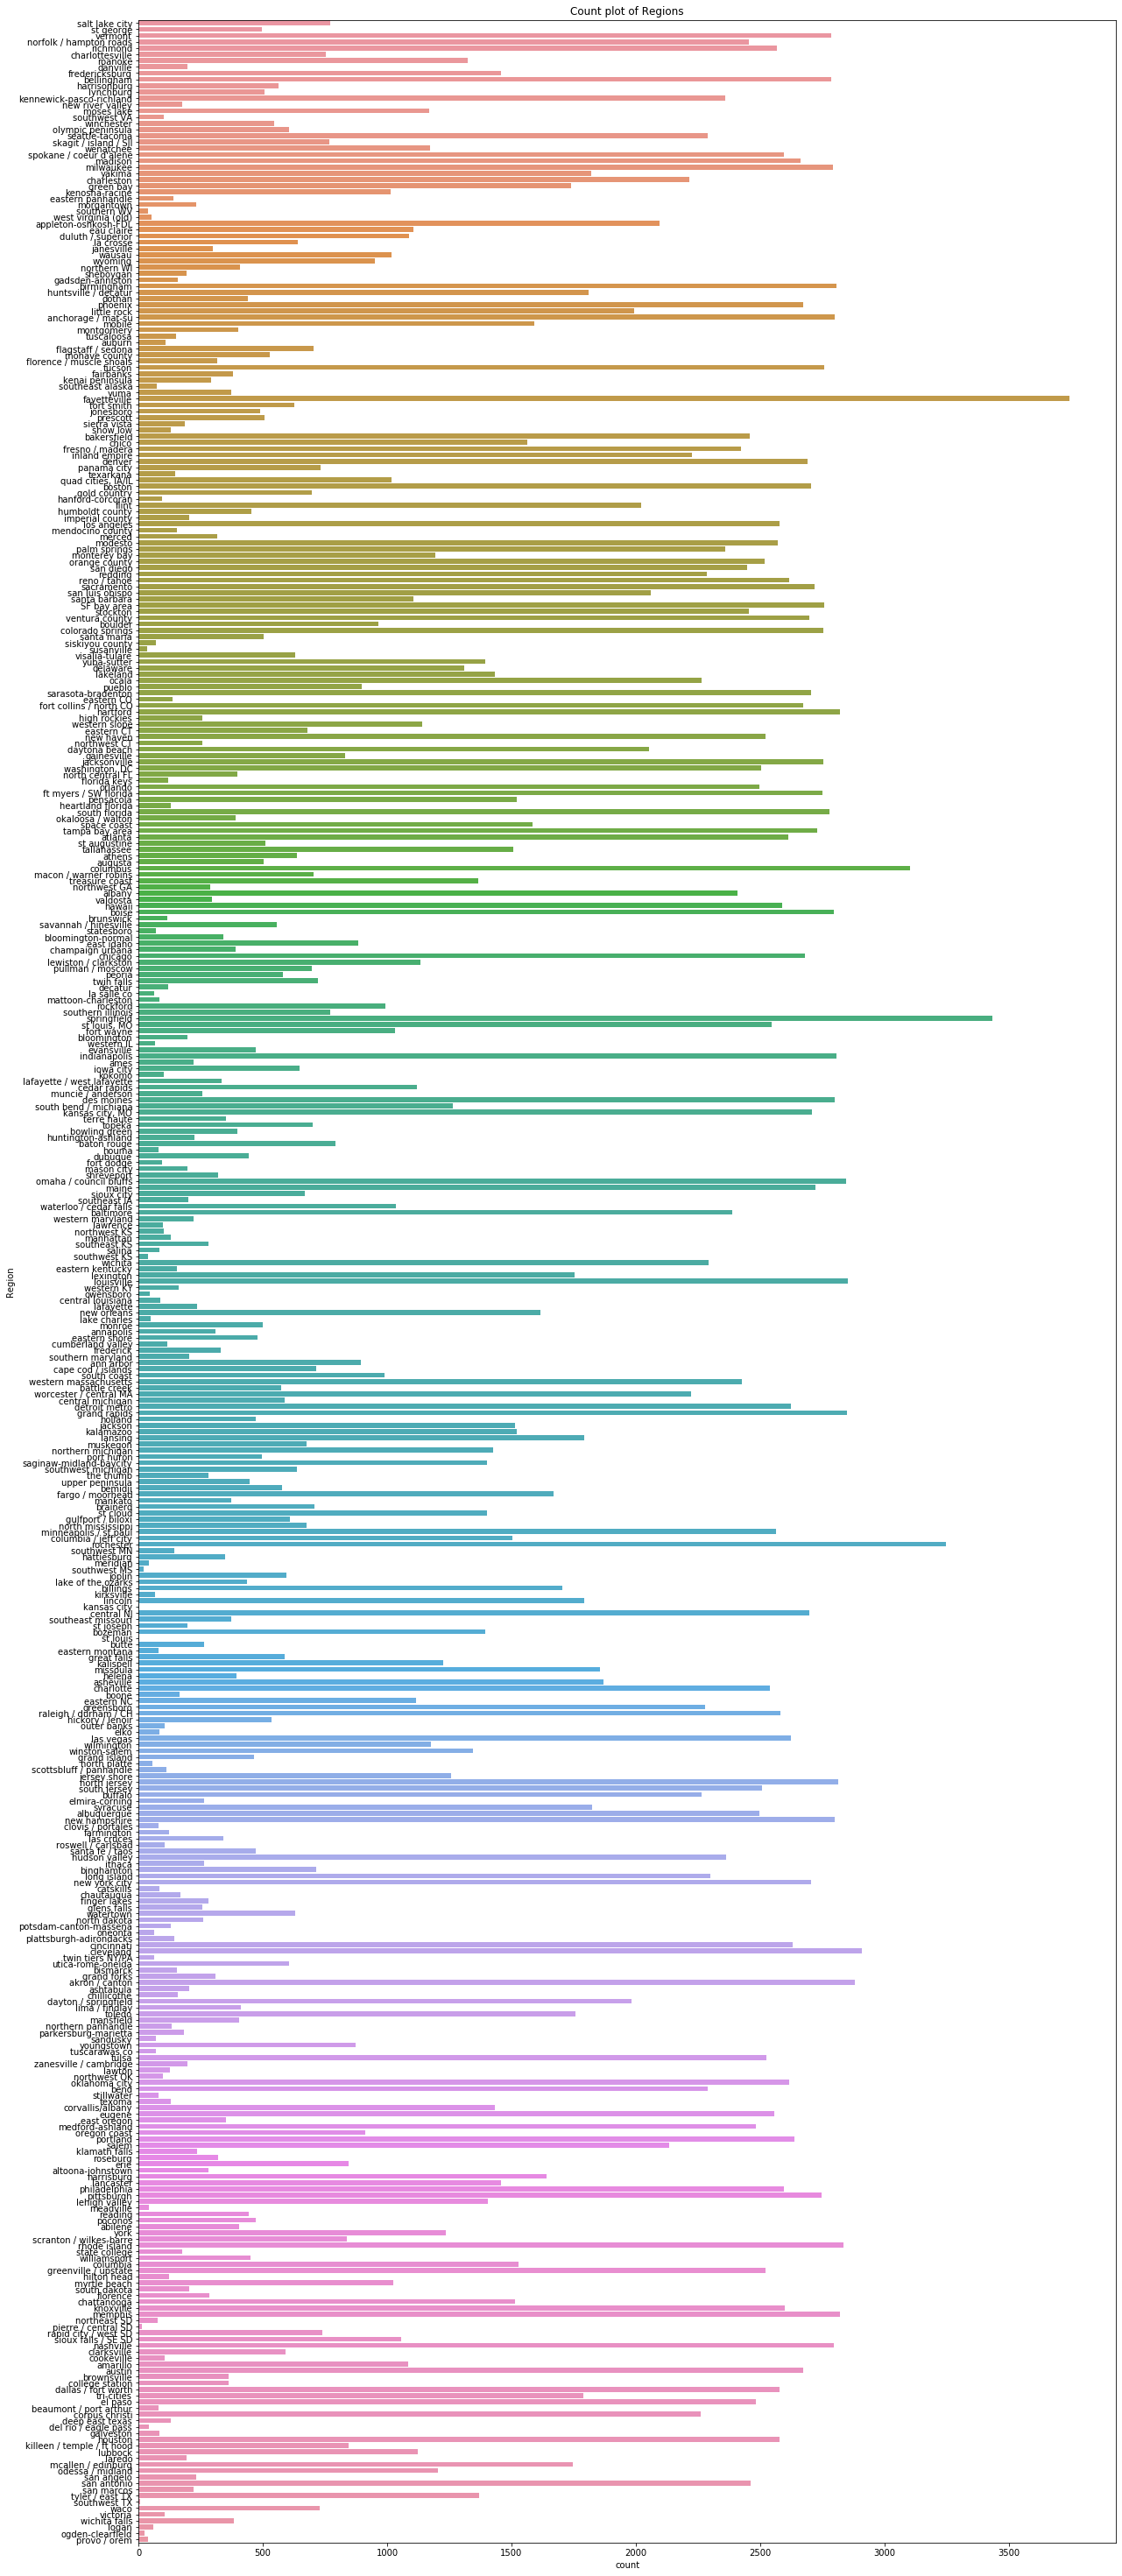

In [15]:
plt.figure(figsize = (20,53))
region_count_plot = sns.countplot(data = new_data, y = "region")
plt.ylabel("Region")
plt.title("Count plot of Regions")
plt.show()

#### The number of Region URLs is very very close to the number of regions, so we think that it could highly correlated with each other. But since they are not exactly the same, we will leave it in the model for now.

In [16]:
np.unique(new_data['region_url']).shape

(413,)

In [17]:
np.unique(new_data['region']).shape

(403,)

#### When we look at the feature "year", it appears to be numerical and ascending, so it should be included. Maybe we need to shrink the data, because some years have so small number of observations.

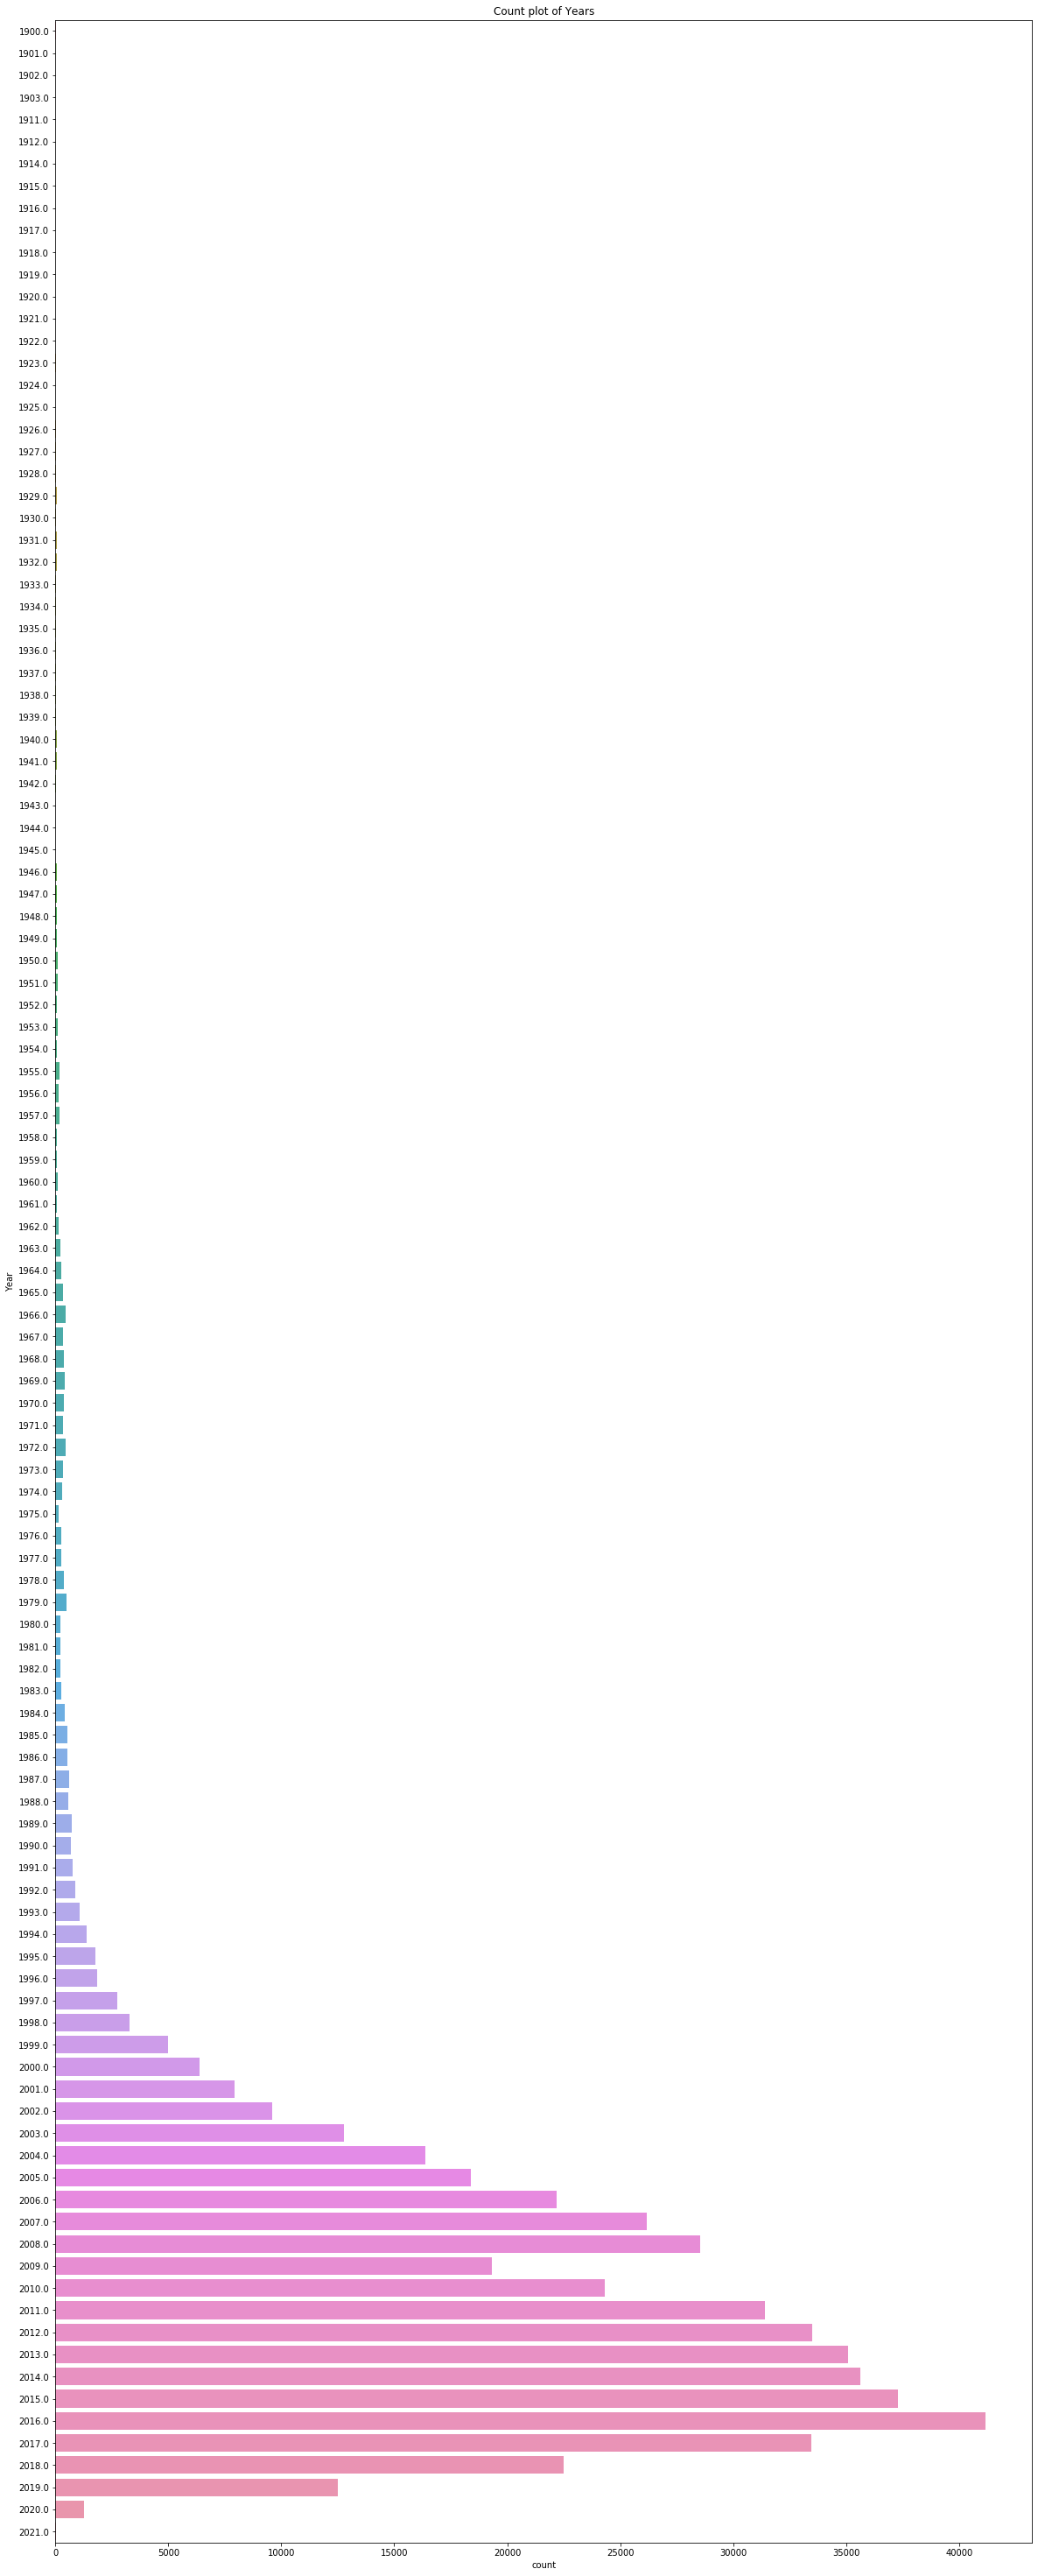

In [18]:
plt.figure(figsize = (20,53))
year_count_plot = sns.countplot(data = data, y = "year")
plt.ylabel("Year")
plt.title("Count plot of Years")
plt.show()

#### Manufacturer is a categorical feature that can be kept. 

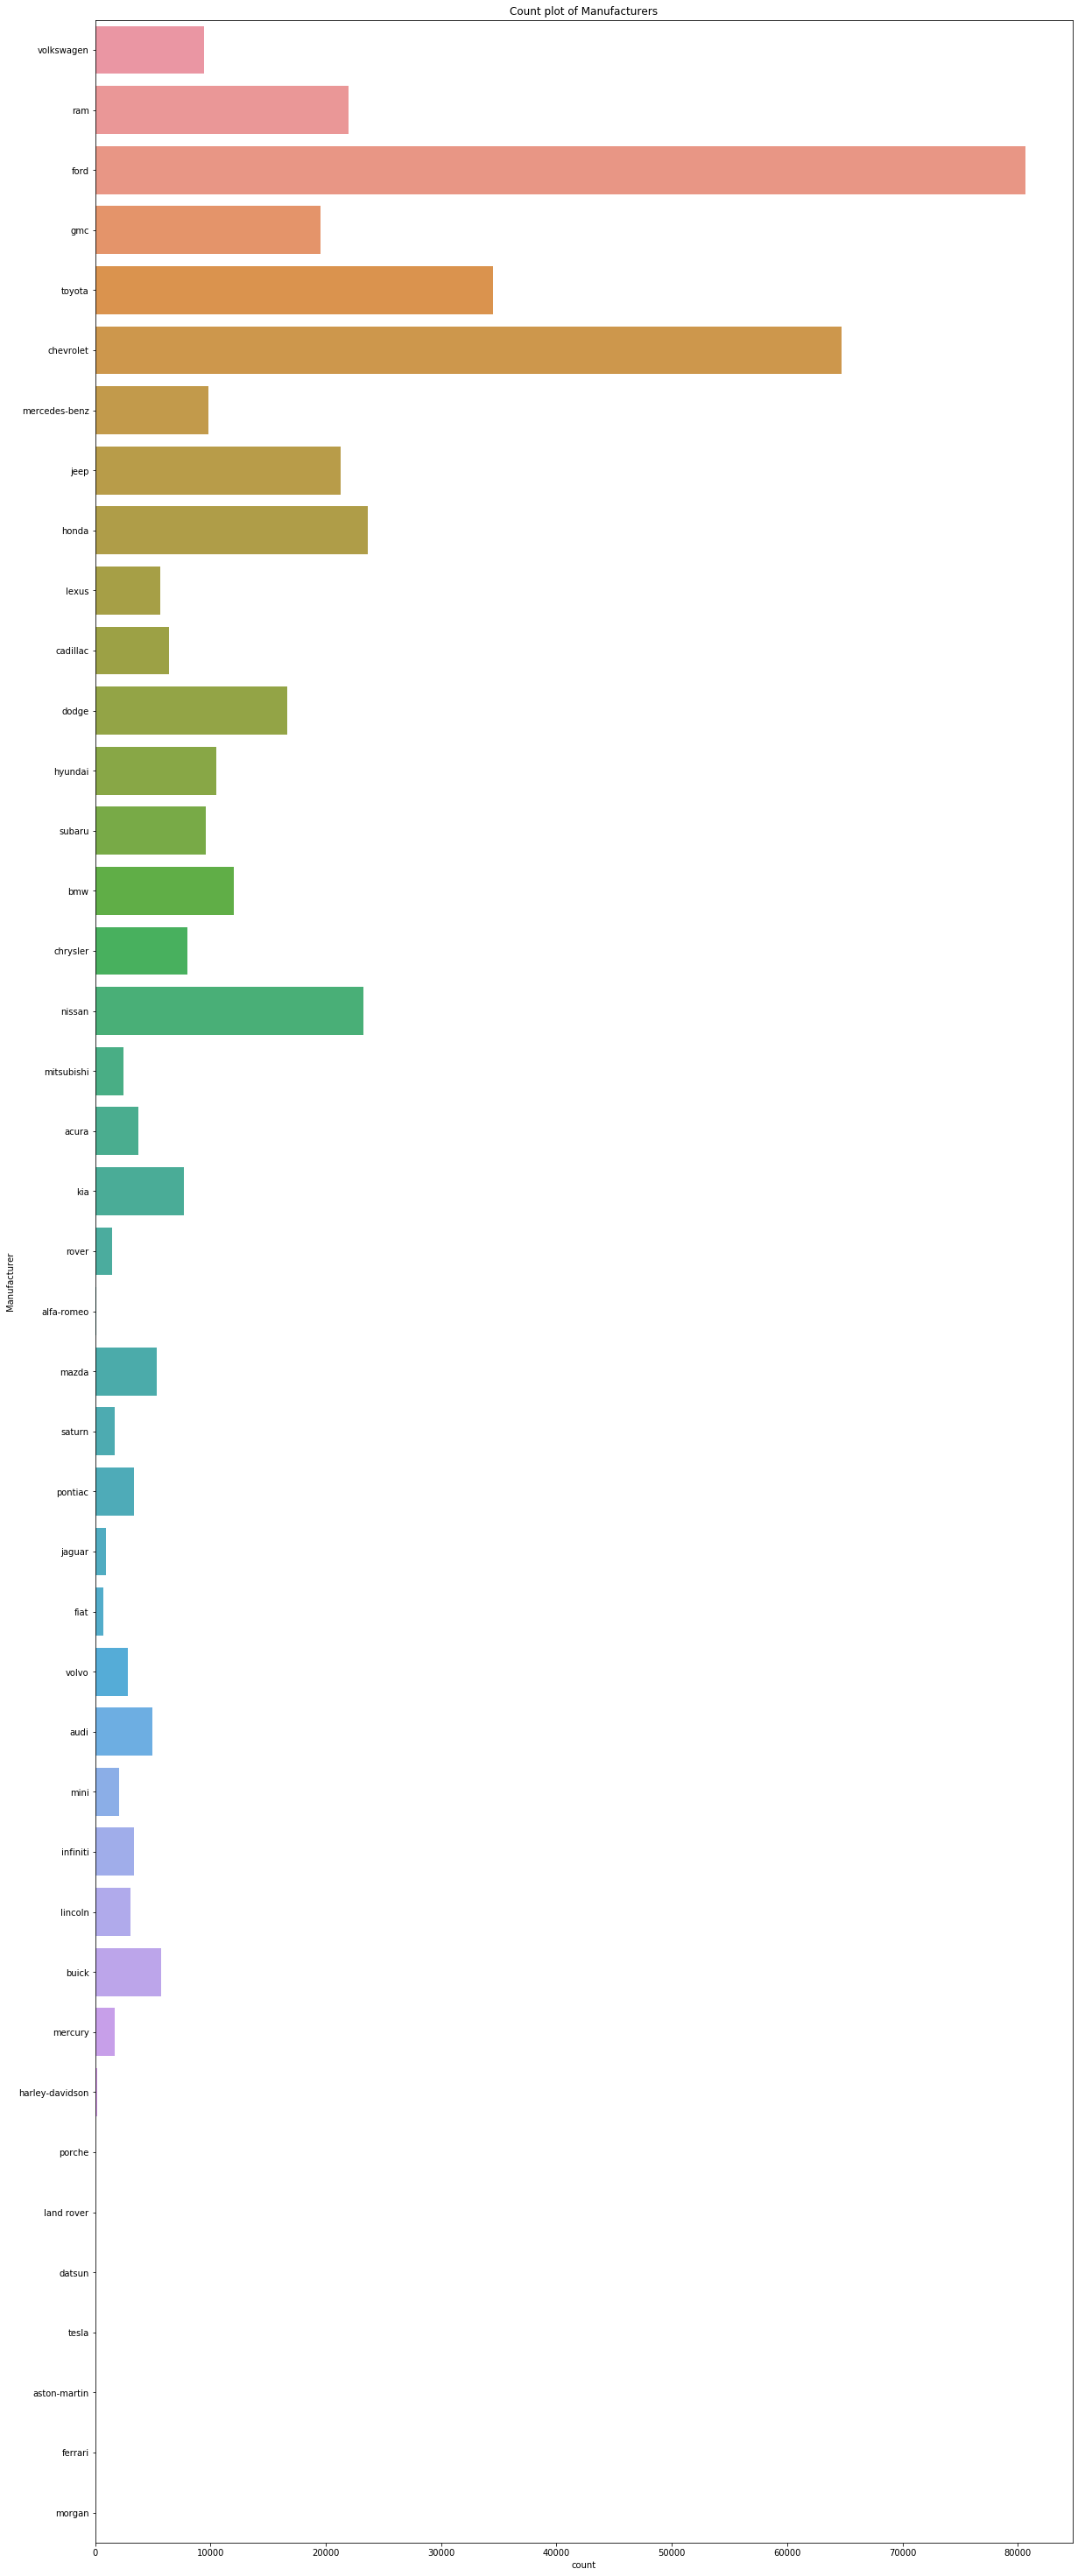

In [19]:
plt.figure(figsize = (20,53))
region_count_plot = sns.countplot(data = new_data, y = "manufacturer")
plt.ylabel("Manufacturer")
plt.title("Count plot of Manufacturers")
plt.show()

#### There are total of 32834 models in this data set. Some models have a lot of observations, while others only have 1 or 2. We will keep this as a category for now, and consider about interactions later.

In [20]:
new_data['model'].value_counts()

f-150                             10009
silverado 1500                     6353
1500                               6244
silverado                          4680
accord                             3589
                                  ...  
forester awd l                        1
1993 Isuzu                            1
1/2 ton short wide bed                1
express passenger lt automatic        1
pickup flat bed                       1
Name: model, Length: 32834, dtype: int64

In [21]:
new_data['model'].value_counts().count()

32834

#### Condition can be kept as a categorical variable, and use one-hot encoder to impute. 

In [22]:
new_data['condition'].value_counts()

excellent    125376
good          93361
like new      25022
fair           9316
new             890
salvage         657
Name: condition, dtype: int64

#### Cylinders can also be kept as a categorical variable, and use one-hot encoder to impute.

In [23]:
new_data['cylinders'].value_counts()

6 cylinders     100648
4 cylinders      86731
8 cylinders      82715
5 cylinders       2625
10 cylinders      1567
other             1107
3 cylinders        487
12 cylinders       101
Name: cylinders, dtype: int64

#### Fuel

In [24]:
new_data['fuel'].value_counts()

gas         394747
diesel       32507
other        12991
hybrid        3631
electric       569
Name: fuel, dtype: int64

#### Odometer

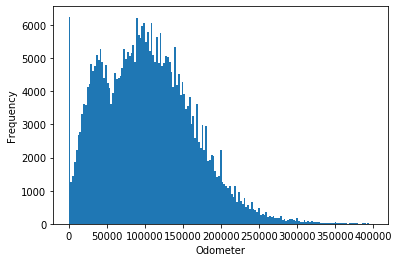

In [25]:
plt.hist(new_data[(new_data['odometer'] > 0) & (new_data['odometer'] < 4 * 1e5)]['odometer'], bins = "auto")
plt.xlabel("Odometer")
plt.ylabel("Frequency")
plt.show()

#### Title Status

In [26]:
new_data['title_status'].value_counts()

clean         426337
rebuilt        10231
salvage         5234
lien            2586
missing          570
parts only       169
Name: title_status, dtype: int64

#### Transmission

In [27]:
new_data['transmission'].value_counts()

automatic    401878
manual        30860
other         12031
Name: transmission, dtype: int64

#### Vin
There are lots of missing values in the "vin" column, plus there are also a lot of unique vin (as it should be), so there is potential leaking information if we use this column.

In [28]:
new_data['vin'].unique().shape

(157134,)

In [29]:
new_data = new_data.drop('vin', axis=1)

#### Drive

In [30]:
new_data['drive'].value_counts()

4wd    146134
fwd    114454
rwd     60470
Name: drive, dtype: int64

#### Size
There are only 167574 observations with size not missing. So we consider use only the type column, since they should be highly correlated. 

In [31]:
new_data['size'].value_counts()

full-size      81771
mid-size       43143
compact        22210
sub-compact     3493
Name: size, dtype: int64

In [32]:
new_data = new_data.drop('size', axis=1)

#### Type

In [33]:
new_data['type'].value_counts()

sedan          83263
SUV            81278
pickup         43188
truck          41374
coupe          16518
hatchback      11688
other          11207
wagon          10053
van             9542
convertible     6839
mini-van        6709
offroad          707
bus              600
Name: type, dtype: int64

#### Paint Color
One hot encoder can be used.

In [34]:
new_data['paint_color'].value_counts()

white     77567
black     61108
silver    46121
blue      31467
red       30810
grey      29898
green      8676
custom     8312
brown      7149
yellow     2308
orange     1878
purple      786
Name: paint_color, dtype: int64

#### Image URL and Description

In [35]:
new_data = new_data.drop(['image_url', 'description'], axis = 1)

#### State

In [36]:
new_data['state'].value_counts()

ca    45593
fl    30788
tx    25744
ny    19978
mi    19391
oh    17725
or    15352
nc    15200
pa    14628
wi    13976
wa    12993
tn    12694
co    11517
va    10496
il    10488
ia    10274
nj     9275
mn     9246
ma     9058
id     8810
az     7862
al     7781
mt     7499
sc     7352
in     6958
ks     6432
ct     6281
ga     6105
ar     5782
mo     5775
ky     5592
ok     5576
md     4050
nm     3623
ak     3547
la     3437
ri     2835
nh     2800
vt     2785
me     2722
nv     2718
hi     2590
dc     2505
ne     2424
ms     2292
sd     2087
ut     1387
de     1310
wy      951
wv      809
nd      726
Name: state, dtype: int64

#### Longitutde and latitude
It seems like longitude and latitude has nothing to do with the price, so we would better drop it.

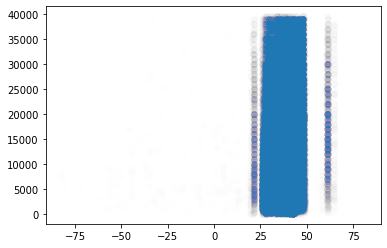

In [37]:
plt.plot(new_data['lat'], new_data['price'],'o', alpha = 0.005)
plt.show()

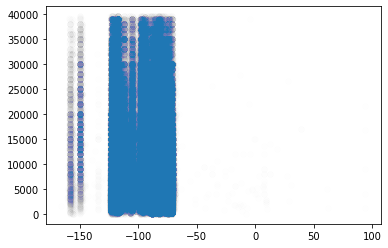

In [38]:
plt.plot(new_data['long'], new_data['price'],'o', alpha = 0.005)
plt.show()

In [39]:
new_data.index = np.arange(0, len(new_data))

In [40]:
new_data = new_data.drop(['long', 'lat'], axis = 1)

## Task 2

In [41]:
sample = new_data.sample(n = 10000)

In [42]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 27612 to 354457
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        10000 non-null  object 
 1   region_url    10000 non-null  object 
 2   price         10000 non-null  int64  
 3   year          9980 non-null   float64
 4   manufacturer  9565 non-null   object 
 5   model         9854 non-null   object 
 6   condition     5726 non-null   object 
 7   cylinders     6188 non-null   object 
 8   fuel          9924 non-null   object 
 9   odometer      8139 non-null   float64
 10  title_status  9946 non-null   object 
 11  transmission  9938 non-null   object 
 12  drive         7081 non-null   object 
 13  type          7185 non-null   object 
 14  paint_color   6826 non-null   object 
 15  state         10000 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 1.3+ MB


In [43]:
X = sample.drop('price', axis = 1)
y = sample['price']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [45]:
numerical = X_train.dtypes == "float64"
one_hot = X_train.dtypes == "object"

In [46]:
one_hot.region = False
one_hot.region_url = False
one_hot.manufacturer = False
one_hot.model = False

In [47]:
target = ~one_hot
target.year = False
target.odometer = False

In [50]:
preprocess = make_column_transformer((StandardScaler(), numerical),
                                     (SimpleImputer(strategy="median"), numerical),
                                     (SimpleImputer(strategy="most_frequent"), ~numerical),
                                     (OneHotEncoder(handle_unknown="ignore"), one_hot),
                                     (TargetEncoder(), target)
                                    )

In [51]:
LinearR_model = make_pipeline(preprocess, LinearRegression())

In [52]:
linearR_score = cross_val_score(LinearR_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(linearR_score))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN

  FitFailedWarning)


nan


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN

  FitFailedWarning)
